# Intercomparison

**Author:** Hannah Kerner

**Last updated:** February 20, 2024

**Description:** Runs intercomparison for Mali 2019

## 1. Setup

In [ ]:
# !earthengine authenticate

In [9]:
import ee
import geemap
import sys
import pandas as pd
import geopandas as gpd
import numpy as np

ee.Initialize()

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL, get_ensemble_area
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

## 2. Read in evaluation set

In [34]:
country = "Mali"
country_code = TEST_CODE[country]
dataset_path = "../" + TEST_COUNTRIES[country]

In [53]:
df = gpd.read_file('mali2019-reference-points.shp')
df.head()

,lon,lat,crop_label,num_labele,geometry
0,-3.310292,20.692693,0.0,2,POINT (-3.31029 20.69269)
1,-5.124889,18.689449,0.0,2,POINT (-5.12489 18.68945)
2,-1.217217,17.324010,0.0,2,POINT (-1.21722 17.32401)
3,0.588397,19.803360,0.0,2,POINT (0.58840 19.80336)
4,-1.351965,19.147590,0.0,2,POINT (-1.35196 19.14759)


In [54]:
df['crop_label'].value_counts()

0.0    437
1.0     10
Name: crop_label, dtype: int64

In [38]:
df[CLASS_COL] = (df["crop_label"] > 0.5).astype(int)
df[COUNTRY_COL] = country

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

/Users/hkerner/anaconda3/envs/landcover-mapping/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [41]:
gdf.head()

,lon,lat,crop_label,num_labele,geometry,binary,country
0,-3.310292,20.692693,0.0,2,POINT (-3.31029 20.69269),0,Mali
1,-5.124889,18.689449,0.0,2,POINT (-5.12489 18.68945),0,Mali
2,-1.217217,17.324010,0.0,2,POINT (-1.21722 17.32401),0,Mali
3,0.588397,19.803360,0.0,2,POINT (0.58840 19.80336),0,Mali
4,-1.351965,19.147590,0.0,2,POINT (-1.35196 19.14759),0,Mali


## 3. Run intercomparison

In [42]:
TARGETS = {k:v for k,v in TARGETS.items() if k != "harvest-dev"}

In [43]:
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")
    gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

[Mali] sampling copernicus...
[Mali] sampling worldcover-v100...
[Mali] sampling worldcover-v200...
[Mali] sampling worldcereal-v100...
[Mali] sampling glad...
[Mali] sampling asap...
[Mali] sampling dynamicworld...
[Mali] sampling gfsad-gcep...
[Mali] sampling gfsad-lgrip...
[Mali] sampling digital-earth-africa...
[Mali] sampling esa-cci-africa...
[Mali] sampling globcover-v23...
[Mali] sampling globcover-v22...
[Mali] sampling esri-lulc...
[Mali] sampling nabil-etal-2021...


In [7]:
a_j = {}
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] calculating pixel area for " + cropmap.title + "...")
    a_j[cropmap.title] = cropmap.compute_map_area(country, export=True, dataset_name=cropmap.title).copy()

[Mali] calculating pixel area for copernicus...
Export task started for copernicus map of Mali. Returning null area for now.
[Mali] calculating pixel area for worldcover-v100...
Export task started for worldcover-v100 map of Mali. Returning null area for now.
[Mali] calculating pixel area for worldcover-v200...
Export task started for worldcover-v200 map of Mali. Returning null area for now.
[Mali] calculating pixel area for worldcereal-v100...
Export task started for worldcereal-v100 map of Mali. Returning null area for now.
[Mali] calculating pixel area for glad...
Export task started for glad map of Mali. Returning null area for now.
[Mali] calculating pixel area for asap...
Export task started for asap map of Mali. Returning null area for now.
[Mali] calculating pixel area for dynamicworld...
Export task started for dynamicworld map of Mali. Returning null area for now.
[Mali] calculating pixel area for gfsad-gcep...
Export task started for gfsad-gcep map of Mali. Returning null ar

In [45]:
# update a_j values with exported values
a_j = {} 
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    area_df = pd.read_csv(f'/Users/hkerner/data/intercomparison/gee-area-exports/mali/Crop_NonCrop_Area_Sum_Export-Mali-{cropmap.title}.csv')
    crop_area = int(area_df['crop_sum'][0])
    noncrop_area = int(area_df['noncrop_sum'][0])
    a_j[cropmap.title] = np.array([noncrop_area, crop_area])

In [46]:
comparisons = []
for cropmap in TARGETS.keys():
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap], a_j[cropmap], area_weighted=True)
    comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])

/Users/hkerner/src/crop-mask/maps/Mali_2019/../../src/area_utils.py:364: RuntimeWarning: invalid value encountered in divide
  area_matrix = (w_j * cm) / n_dotj
/Users/hkerner/src/crop-mask/maps/Mali_2019/../../src/area_utils.py:385: RuntimeWarning: invalid value encountered in divide
  u_j = p_jjs / p_dotjs
/Users/hkerner/src/crop-mask/maps/Mali_2019/../../src/area_utils.py:454: RuntimeWarning: divide by zero encountered in divide
  n_i_px = ((a_j / cm.sum(axis=0) * cm).sum(axis=1)).astype(np.uint64)
/Users/hkerner/src/crop-mask/maps/Mali_2019/../../src/area_utils.py:454: RuntimeWarning: invalid value encountered in multiply
  n_i_px = ((a_j / cm.sum(axis=0) * cm).sum(axis=1)).astype(np.uint64)
/Users/hkerner/src/crop-mask/maps/Mali_2019/../../src/area_utils.py:454: RuntimeWarning: invalid value encountered in cast
  n_i_px = ((a_j / cm.sum(axis=0) * cm).sum(axis=1)).astype(np.uint64)
/Users/hkerner/src/crop-mask/maps/Mali_2019/../../src/area_utils.py:463: RuntimeWarning: invalid valu

In [47]:
# Add ensemble
ensemble_maps = ["glad", "worldcover-v100", "esri-lulc", "digital-earth-africa",
                 "dynamicworld", "esa-cci-africa", "gfsad-gcep", "nabil-etal-2021",
                 "copernicus", "globcover-v23", "asap"] # Should be odd number
print(f"Ensemble maps: {ensemble_maps}")
ensemble = gdf[ensemble_maps].mode(axis='columns')
a_j['ensemble-subset'] = get_ensemble_area(country, [TARGETS[name] for name in ensemble_maps], export=True)

Ensemble maps: ['glad', 'worldcover-v100', 'esri-lulc', 'digital-earth-africa', 'dynamicworld', 'esa-cci-africa', 'gfsad-gcep', 'nabil-etal-2021', 'copernicus', 'globcover-v23', 'asap']
Export task started for ensemble map of Mali. Returning null area for now.


In [48]:
# update a_j values with exported ensemble values
area_df = pd.read_csv(f'/Users/hkerner/data/intercomparison/gee-area-exports/mali/Crop_NonCrop_Ensemble_Area_Sum_Export-Mali.csv')
crop_area = int(area_df['crop_sum'][0])
noncrop_area = int(area_df['noncrop_sum'][0])
a_j['ensemble-subset'] = np.array([noncrop_area, crop_area])

In [49]:
comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble, a_j['ensemble-subset'], area_weighted=True)
comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])
results

,country,crop_f1,std_crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,noncrop_recall_pa,std_noncrop_pa,crop_precision_ua,...,crop_support,noncrop_support,tn,fp,fn,tp,tn_area,fp_area,fn_area,tp_area
dataset,,,,,,,,,,,,,,,,,,,,,
copernicus,Mali,0.18,0.23,0.93,0.01,0.37,0.15,0.94,0.00,0.12,...,10,437,407,30,6,4,0.92,0.06,0.01,0.01
worldcover-v100,Mali,0.43,0.21,0.95,0.01,0.81,0.05,0.95,0.11,0.30,...,10,437,418,19,2,8,0.93,0.04,0.00,0.02
worldcover-v200,Mali,0.45,0.22,0.95,0.01,0.81,0.05,0.96,0.10,0.31,...,10,437,419,18,2,8,0.94,0.04,0.00,0.02
worldcereal-v100,Mali,0.36,0.25,0.95,0.01,0.62,0.09,0.95,0.14,0.25,...,10,437,419,18,4,6,0.93,0.04,0.01,0.01
glad,Mali,0.33,0.29,0.96,0.01,0.61,0.16,0.96,0.00,0.23,...,10,437,413,24,3,7,0.95,0.04,0.01,0.01
asap,Mali,0.21,0.38,0.95,0.01,0.27,0.15,0.97,0.00,0.17,...,10,437,427,10,8,2,0.94,0.03,0.02,0.01
dynamicworld,Mali,0.12,0.22,0.94,0.01,0.18,0.10,0.96,0.04,0.09,...,10,437,416,21,8,2,0.94,0.04,0.02,0.00
gfsad-gcep,Mali,0.15,0.20,0.91,0.01,0.37,0.15,0.92,0.00,0.10,...,10,437,399,38,6,4,0.90,0.08,0.01,0.01
gfsad-lgrip,Mali,0.17,0.22,0.91,0.01,0.40,0.15,0.93,0.00,0.11,...,10,437,405,32,6,4,0.91,0.07,0.01,0.01


In [50]:
results.to_csv('/Users/hkerner/Documents/Publications/Crop Mask Intercomparison/map-notebook-outputs/mali-2019-results.csv')

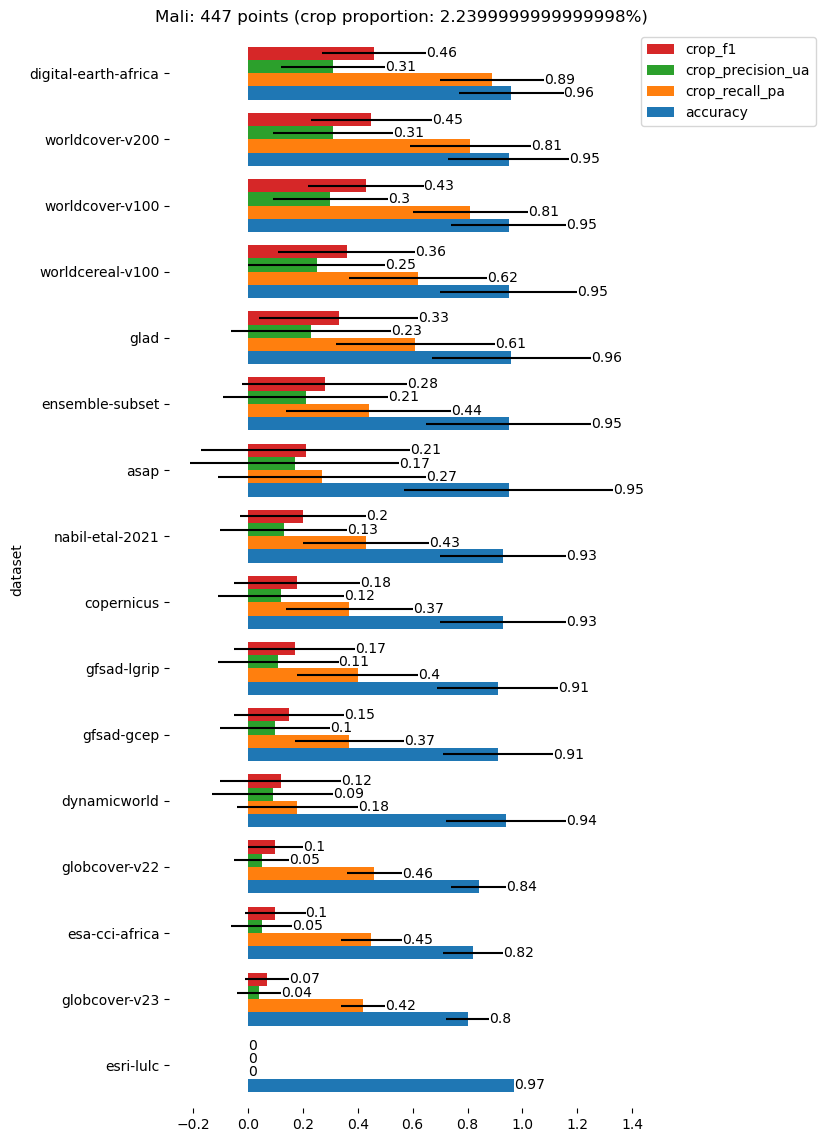

In [51]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"], 
    xerr="std_crop_f1",
    kind="barh", 
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

## 4. Visualize best available map

In [52]:
# Run this cell to view and export map
print("To view and export map copy and paste the text below the dashed line into GEE\n" + "-"*100)
best_dataset = results["crop_f1"].idxmax()
if best_dataset in TARGETS:
    print(TARGETS[best_dataset].ee_script(country))
else:
    image_var_names = [TARGETS[d].title_safe for d in ensemble_maps]
    for i, dataset in enumerate(ensemble_maps):
        print(TARGETS[dataset].ee_script(country, include_prefix=(i == 0), include_export=False))
        print("\n")
    print(f"var ensemble = ee.ImageCollection.fromImages([{', '.join(image_var_names)}]).mode()")
    print(f"Map.addLayer(ensemble, classVis, 'Cropland from ensemble');")
    print(f"""
Export.image.toCloudStorage({{
    image: ensemble,
    description: "{country}_ensemble_{'_'.join(image_var_names)}",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: "{country}_ensemble_{'_'.join(image_var_names)}",
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e10,
    skipEmptyTiles: true
}});""")

To view and export map copy and paste the text below the dashed line into GEE
----------------------------------------------------------------------------------------------------

var palettes = require('users/gena/packages:palettes');
var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}
var aoi = ee.FeatureCollection("FAO/GAUL/2015/level0")
    .filter(ee.Filter.eq('ADM0_NAME', 'Mali'));
Map.centerObject(aoi, 7);

var digital_earth_africa = ee.ImageCollection([ee.Image(0)
            .where(ee.ImageCollection("projects/sat-io/open-datasets/DEAF/CROPLAND-EXTENT/filtered")
            .mosaic()
            .eq(1), 1)]
        ).filterBounds(aoi).mosaic().clip(aoi);
digital_earth_africa = digital_earth_africa.eq(1).rename('crop')
Map.addLayer(digital_earth_africa, classVis, 'Cropland from digital-earth-africa');
Export.image.toCloudStorage({
    image: digital_earth_africa,
    description: "Mali_digital_earth_africa",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: 